# Plot diffusion gradient based on the code of Emmanuel Caruyer

In [1]:
################################################
# Author: Emmanuel Caruyer <caruyer@gmail.com> #
#                                              #
# Code to generate multiple-shell sampling     #
# schemes, with optimal angular coverage. This #
# implements the method described in Caruyer   #
# et al., MRM 69(6), pp. 1534-1540, 2013.      #
# This software comes with no warranty, etc.   #
################################################
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import art3d
import numpy as np


_epsi = 1.0e-9


def rotation_matrix(u, v):
    """
    returns a rotation matrix R s.t. Ru = v
    """
    # the axis is given by the product u x v
    u = u / np.sqrt((u ** 2).sum())
    v = v / np.sqrt((v ** 2).sum())
    w = np.asarray([u[1] * v[2] - u[2] * v[1], 
                    u[2] * v[0] - u[0] * v[2], 
                    u[0] * v[1] - u[1] * v[0]])
    if (w ** 2).sum() < _epsi:
        #The vectors u and v are collinear
        return np.eye(3)

    # computes sine and cosine
    c = np.dot(u, v)
    s = np.sqrt((w ** 2).sum())

    w = w / s
    P = np.outer(w, w)
    Q = np.asarray([[0, -w[2], w[1]], [w[2], 0, -w[0]], [-w[1], w[0], 0]])
    R = P + c * (np.eye(3) - P) + s * Q
    return R


def draw_circles(positions, rs):
    """
    draw circular patches (lying on a sphere) at given positions.
    """
    # a circle centered at [1, 0, 0] with radius r
    M = 20
    t = np.linspace(0, 2 * np.pi, M)
    
    nbPoints = positions.shape[0]
    circles = np.zeros((nbPoints, M, 3))
    for i in range(positions.shape[0]):
        circleX = np.zeros((20, 3))
        dots_radius = np.sqrt(rs[i]) * 0.04
        circleX[:, 1] = dots_radius * np.cos(t)
        circleX[:, 2] = dots_radius * np.sin(t)
        norm = np.sqrt((positions[i] ** 2).sum())
        point = positions[i] / norm 
        R1 = rotation_matrix(np.asarray([1, 0, 0]), point)
        circles[i] = positions[i] + np.dot(R1, circleX.T).T
    return circles


def draw_points(gradients, ax, r_max=None, colormap='viridis'):
    """
    Draw the vectors on multi-shell. 
    Parameters
    ----------
    gradients : array-like shape (N, 4) 
            Contains unit vectors. Shells should be stored consecutively.
    ax : the matplolib axes instance to plot in.
    """
    # Initialize 3D view
    elev = 90
    azim = 0  
    ax.view_init(azim=azim, elev=elev)
    
    # Normalize to 1 the highest bvalue
    bvals = np.copy(gradients[3,:])
    rs = bvals / bvals.max()
    
    if r_max is None:
        r_max = np.max(rs)
        
    # Color map depending on bvalue (for visualization)
    cm = plt.cm.get_cmap(colormap)
    colors = cm(rs / r_max)
    
    # Relative shell radii proportional to the inverse of bvalue (for visualization)
    rs = np.reciprocal(rs)
    rs = rs / rs.max()
    rs = rs - rs.min()
    rs = rs / (rs.max()-rs.min())
    rs = rs * (0.7 - 0.4) + 0.4

    vects = np.copy(gradients[:3,:].T,)
    vects[vects[:, 2] < 0] *= -1
    
    circles = draw_circles(vects, rs)
    ax.add_collection(
        art3d.Poly3DCollection(
            circles,
            facecolors=colors,
            linewidth=0
        )
    )
    
    max_val = 0.6 * r_max
    ax.set_xlim(-max_val, max_val)
    ax.set_ylim(-max_val, max_val)
    ax.set_zlim(-max_val, max_val)
    ax.axis("off")

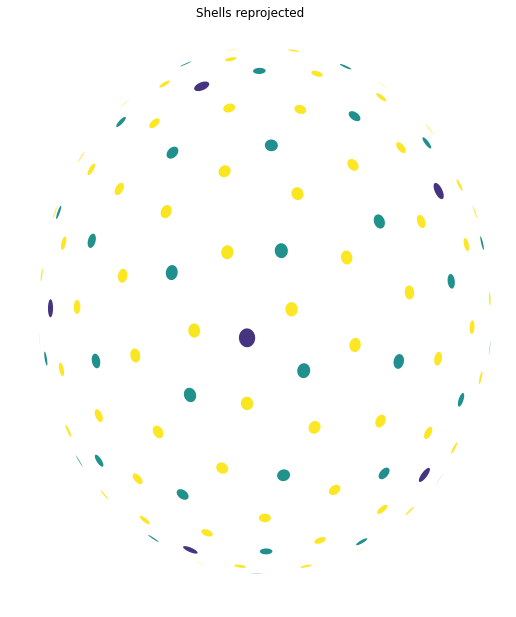

In [2]:
from eddymotion.dmri import DWI
data = DWI.from_filename("/Users/sebastientourbier/Downloads/dwi.h5")

def plot_gradients(gradients, title="Shells reprojected", spacing = 0.05, filename=None, **kwargs):
    # Visualization after reprojecting all shells to the unit sphere
    fig = plt.figure(figsize=(9.0, 9.0))
    ax = fig.add_subplot(111, projection='3d')
    plt.subplots_adjust(bottom=spacing,
                        top=1 - spacing,
                        wspace=2*spacing)   
    draw_points(gradients, ax, **kwargs)
    plt.suptitle(title)
    if filename:
        plt.savefig(filename, dpi=200)
plot_gradients(data.gradients, colormap='viridis')